# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"
plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler slave_gpu_ctx

In [5]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [6]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [7]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

## Simulation

In [8]:
loc = [[50,50],[250,450]]
scale = 1.5

In [9]:
from gpuocean.SWEsimulators import CDKLM16, CDKLM16pair

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)
sim.give_birth(gpu_ctx_refined, loc, scale)

slave = CDKLM16.CDKLM16(slave_gpu_ctx, **sim_args, **data_args)  

sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, small_scale_model_error=True, interpolation_factor=21)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [10]:
sim_pair.step(300)

300.0

In [11]:
eta0, hu0, hv0 = sim_pair.sim.download()
eta1, hu1, hv1 = sim_pair.sim.children[0].download()

slave_eta, slave_hu, slave_hv = sim_pair.slave_sim.download()

Reference

In [12]:
sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args)
sim.give_birth(gpu_ctx_refined, loc, scale)

slave = CDKLM16.CDKLM16(slave_gpu_ctx, **sim_args, **data_args)  

sim_pair = CDKLM16pair.CDKLM16pair(sim, slave, small_scale_model_error=True, interpolation_factor=21)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [13]:
sim_pair.step(300, apply_stochastic_term=True)

300.0

In [14]:
eta0R, hu0R, hv0R = sim_pair.sim.download()
eta1R, hu1R, hv1R = sim_pair.sim.children[0].download()

slave_etaR, slave_huR, slave_hvR = sim_pair.slave_sim.download()

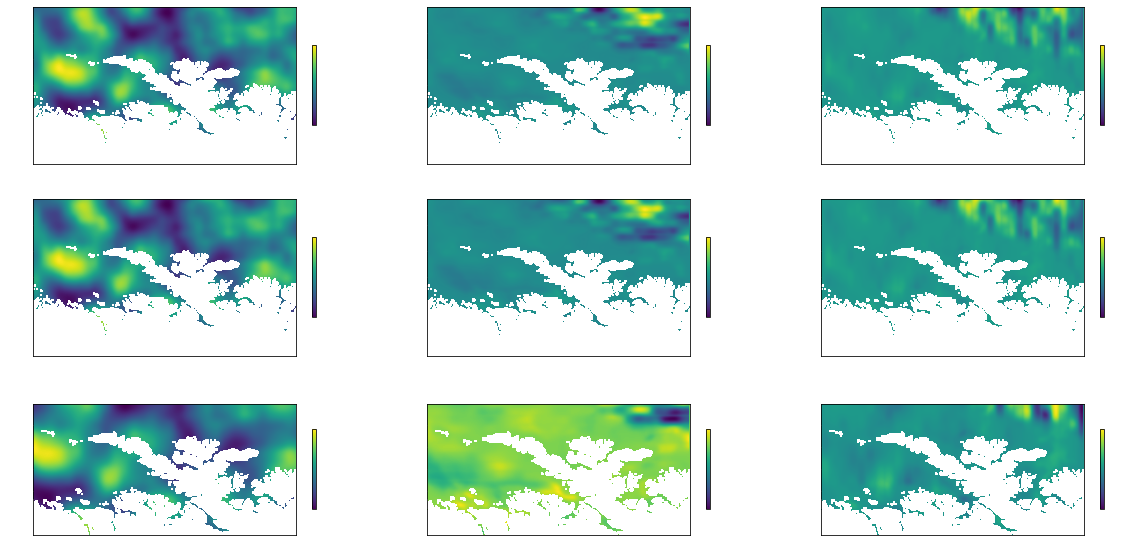

In [15]:
fig, axs = plt.subplots(3,3, figsize=(20,10))

im = axs[0,0].imshow(eta0R - eta0, origin="lower")
plt.colorbar(im, ax=axs[0,0], shrink=0.5)

im = axs[0,1].imshow(hu0R - hu0, origin="lower")
plt.colorbar(im, ax=axs[0,1], shrink=0.5)

im = axs[0,2].imshow(hv0R - hv0, origin="lower")
plt.colorbar(im, ax=axs[0,2], shrink=0.5)

im = axs[1,0].imshow(slave_etaR - slave_eta, origin="lower")
plt.colorbar(im, ax=axs[1,0], shrink=0.5)

im = axs[1,1].imshow(slave_huR - slave_hu, origin="lower")
plt.colorbar(im, ax=axs[1,1], shrink=0.5)

im = axs[1,2].imshow(slave_hvR - slave_hv, origin="lower")
plt.colorbar(im, ax=axs[1,2], shrink=0.5)

im = axs[2,0].imshow(eta1R - eta1, origin="lower")
plt.colorbar(im, ax=axs[2,0], shrink=0.5)

im = axs[2,1].imshow(hu1R - hu1, origin="lower")
plt.colorbar(im, ax=axs[2,1], shrink=0.5)

im = axs[2,2].imshow(hv1R - hv1, origin="lower")
plt.colorbar(im, ax=axs[2,2], shrink=0.5)